<a href="https://colab.research.google.com/github/xshen796/CodingClubPsych/blob/master/tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colocalization Practical 1
Ville Karhunen 


Autumn 2021

# Introduction

In this practical, we will go through colocalization analysis using coloc package in R software.
We will be investigating the genetic associations of low-density lipoprotein cholesterol (LDL-C) and coronary artery disease (CAD) risk within the vicinity of *HMGCR* gene.

For further details on coloc, please see the excellent documentation of the package at: https://chr1swallace.github.io/coloc/.

Let's start with loading the required packages:



```
library(coloc)
library(data.table)
library(ggplot2)
library(ggpubr)
library(cowplot)
```



#Housekeeping

In this section, we will configure the google colaboratory notebook to be linked with our google drive account, assign it to an R coding environment and set the working directory to your google drive folder. Finally, we will import various libraries from the 'R_libs' folder. 

Note: 
Google cloud platform mostly runs python. However, we can use a magic function (%%R) at the start of every cell to make that cell run R code. That is why you see **%%R** in all of the cells below. This is not required in an environment that is natively designed to run on R, such as Rstudio. 

In [ ]:
#Load up the google drive - note this does not need the R magic function as it is a python code! 
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Enable R - %%R is still required at the start of each cell to run the code in R 
%load_ext rpy2.ipython

In [ ]:
#Set working directory - this uses the python package 'os' to set our working directory as the google drive folder
#Again this is written in python code and we do not need to warn the notebook that the code is in R 
os.chdir('/content/drive/MyDrive')

In [ ]:
#Import libraries in R - note: the use of %%R denoting that the code in this cell is written in R! 
%%R
library(coloc, lib = '/content/drive/MyDrive/coloc_tutorials/R_libs')
library(data.table, lib = '/content/drive/MyDrive/coloc_tutorials/R_libs')
library(ggplot2, lib = '/content/drive/MyDrive/coloc_tutorials/R_libs')
library(ggpubr, lib = '/content/drive/MyDrive/coloc_tutorials/R_libs')
library(cowplot, lib = '/content/drive/MyDrive/coloc_tutorials/R_libs')

R[write to console]: This is a new update to coloc.

R[write to console]: data.table 1.14.2 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Keep up to date with changes at https://www.tidyverse.org/blog/

R[write to console]: 
Attaching package: ‘cowplot’


R[write to console]: The following object is masked from ‘package:ggpubr’:

    get_legend




For inputs, we need the position of the gene in the correct build and the considered window size (in kb).

In [ ]:
%%R
genechr <- 5
genestart <- 74632154
genestop <- 74657929
genewindow <- 200


# Read data

Next, we will read the data in R.

* 'd_ldl.csv' -- chromosome 5 summary statistics for low-density lipoprotein cholesterol from [Willer et al. (2013)](https://doi.org/10.1038/ng.2797). This is available from: 

* 'd_cad.csv' -- chromosome 5 summary statistics for coronary artery disease risk from [Nikpay et al. (2015)](https://doi.org/10.1038/ng.3396).
This is available from: 

In [ ]:
%%R
d_ldl <- fread('https://storage.googleapis.com/gidd_mr_course/d_ldl.csv')
d_cad <- fread('https://storage.googleapis.com/gidd_mr_course/d_cad.csv')

Streaming output truncated to the last 5000 lines.
 [17%] Downloaded 8469348 bytes...
 [17%] Downloaded 8477540 bytes...
 [17%] Downloaded 8485732 bytes...
 [17%] Downloaded 8493924 bytes...
 [17%] Downloaded 8502116 bytes...
 [17%] Downloaded 8510308 bytes...
 [17%] Downloaded 8518500 bytes...
 [17%] Downloaded 8526692 bytes...
 [17%] Downloaded 8534884 bytes...
 [17%] Downloaded 8543076 bytes...
 [17%] Downloaded 8551268 bytes...
 [17%] Downloaded 8559460 bytes...
 [17%] Downloaded 8567652 bytes...
 [17%] Downloaded 8575844 bytes...
 [17%] Downloaded 8584036 bytes...
 [17%] Downloaded 8592228 bytes...
 [17%] Downloaded 8600420 bytes...
 [17%] Downloaded 8608612 bytes...
 [17%] Downloaded 8616804 bytes...
 [17%] Downloaded 8624996 bytes...
 [17%] Downloaded 8633188 bytes...
 [17%] Downloaded 8641380 bytes...
 [17%] Downloaded 8649572 bytes...
 [17%] Downloaded 8657764 bytes...
 [17%] Downloaded 8665956 bytes...
 [17%] Downloaded 8674148 bytes...
 [17%] Downloaded 8682340 bytes...
 [17

First, we merge the data into a single dataset.

In [ ]:
%%R
d <- d_ldl[d_cad, on = c("rsid" = "rsid"), nomatch = NULL]

Next, we select the variants within +/-200 kb of the HMGCR gene.
This is done based on the parameters we gave in the beginning:

In [ ]:
%%R
d <- d[CHR %in% genechr & POS > genestart - 1 - genewindow*1000 & POS < genestop + 1 + genewindow*1000,]


So we are left with `r nrow(d)` variants for colocalization.
In contrast to Mendelian randomization, where we would only use variants strongly associated with the exposure, we use all variants within the genomic region for colocalization analysis.


We can visualize the genetic associations via Manhattan plots:

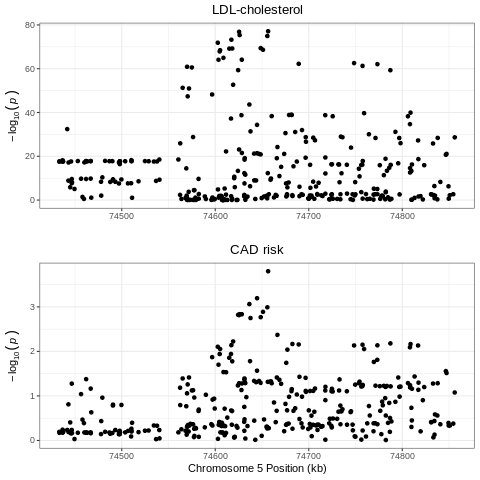

In [ ]:
%%R
p1 <- ggplot(d, aes(x = POS, y = -log10(P_ldl))) +
  geom_point() +
  labs(x = "", y = bquote(-log[10](italic(p))),
       title = "LDL-cholesterol") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_x_continuous(breaks = c(74500000, 74600000, 74700000, 74800000),
                     labels = c(74500, 74600, 74700, 74800))

p2 <- ggplot(d, aes(x = POS, y = -log10(P_cad))) +
  geom_point() +
  labs(x = "", y = bquote(-log[10](italic(p))),
         title = "CAD risk") +
  theme_bw() +
  theme(plot.title = element_text(hjust = 0.5)) +
  scale_x_continuous(name = paste0("Chromosome ", genechr, " Position (kb)"),
                     breaks = c(74500000, 74600000, 74700000, 74800000),
                     labels = c(74500, 74600, 74700, 74800))

ggpubr::ggarrange(p1, p2,
 heights = c(1, 1), nrow = 2, 
 ncol = 1, align = "hv")

Even though 'coloc' does not require data to be aligned between the two traits, I strongly recommend to keep them aligned at all times.
Here, the alleles are aligned to correspond to the minor allele, so it can be checked whether there are any flipped alleles between the two summary statistics.

In [ ]:
%%R
#wrangling data to align alleles 
d[,"EA_ldl_aligned" := ifelse(EAF_ldl < 0.5, EA_ldl, NEA_ldl)]
d[,"NEA_ldl_aligned" := ifelse(EAF_ldl < 0.5, NEA_ldl, EA_ldl)]
d[,"MAF_ldl" := ifelse(EAF_ldl < 0.5, EAF_ldl, 1 - EAF_ldl)]
d[,"BETA_ldl_aligned" := ifelse(EAF_ldl < 0.5, BETA_ldl, -BETA_ldl)]

d[,"EA_cad_aligned" := ifelse(EAF_cad < 0.5, EA_cad, NEA_cad)]
d[,"NEA_cad_aligned" := ifelse(EAF_cad < 0.5, NEA_cad, EA_cad)]
d[,"MAF_cad" := ifelse(EAF_cad < 0.5, EAF_cad, 1 - EAF_cad)]
d[,"BETA_cad_aligned" := ifelse(EAF_cad < 0.5, BETA_cad, -BETA_cad)]

d[,"flipped" := (EA_ldl_aligned != EA_cad_aligned)*1]

         V1       rsid CHR      POS EA_ldl NEA_ldl EAF_ldl     N_ldl BETA_ldl
  1: 116078 rs13360638   5 74433258      A       G 0.40770  89888.00   0.0464
  2: 116079 rs13359143   5 74433360      C       T 0.40770  89888.00   0.0464
  3: 116080  rs1600074   5 74436574      T       C 0.40770  89888.00   0.0463
  4: 116081  rs1600073   5 74436737      T       C 0.39180  89888.00   0.0472
  5: 116082  rs1477933   5 74437153      A       G 0.40770  89888.00   0.0464
 ---                                                                         
332: 116459  rs5744612   5 74849469      G       A 0.10420  89851.00   0.0471
333: 116460  rs5744616   5 74849695      C       T 0.97757  82097.88   0.0241
334: 116461 rs11953173   5 74850806      A       C 0.97757  86937.00   0.0389
335: 116462 rs73764928   5 74854567      T       C 0.10420  83115.10   0.0345
336: 116463  rs9293655   5 74856142      T       C 0.13460 173001.00   0.0642
     SE_ldl     P_ldl   i.V1 chr  bp_hg19 EA_cad NEA_cad  EAF_ca

In [ ]:
%%R
sum(d$flipped) # no flipped alleles

[1] 0


After these data wrangling steps, we can prepare our data for coloc analyses.
For details, see http://chr1swallace.github.io/coloc/articles/a02_data.html.

In [ ]:
%%R
#Data preparation 

D1 <- list(
 type = "quant", # quantitative trait
 beta = d$BETA_ldl_aligned,
 varbeta = d$SE_ldl^2, # note that this is standard error squared
 pvalues = d$P_ldl,
 N = d$N_ldl,
 MAF = d$MAF_ldl,
 snp = d$rsid,
 sdY = 1 # external information
)

D2 <- list(
 type = "cc", # case-control trait
 beta = d$BETA_cad_aligned,
 varbeta = d$SE_cad^2,
 pvalues = d$P_cad,
 N = 60801+123504, # external information
 s = 60801/(60801+123504), # external information
 MAF = d$MAF_cad,
 snp = d$rsid
)

Finally, we can proceed to running the colocalization.
As briefly mentioned in the talk, coloc applies Bayesian inference and therefore requires the following prior probabilities:

* p1: the prior probability for a variant being associated with trait 1 (default 1e-4)

* p2: the prior probability for a variant being associated with trait 2 (default 1e-4)

* p12: the prior probability a variant being associated with both traits (default 1e-5)

Let's use the default values:

In [ ]:
%%R
#Run coloc analysis 
coloc_results <- coloc.abf(D1, D2, p1 = 1e-4, p2 = 1e-4, p12 = 1e-5)

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 2.97e-79  5.67e-01  7.90e-81  1.47e-02  4.18e-01 
[1] "PP abf for shared variant: 41.8%"


The posterior probability for the model with a shared causal variant (PP.H4.abf) is 0.42.
For the distinct causal variants model (PP.H3.abf), the posterior probability is 0.01.

Note that the used prior probability is fairly conservative -- we can examine this assumption *post-hoc*.
For further details, see http://chr1swallace.github.io/coloc/articles/a04_sensitivity.html.

R[write to console]: Results fail decision rule H4 > 0.7



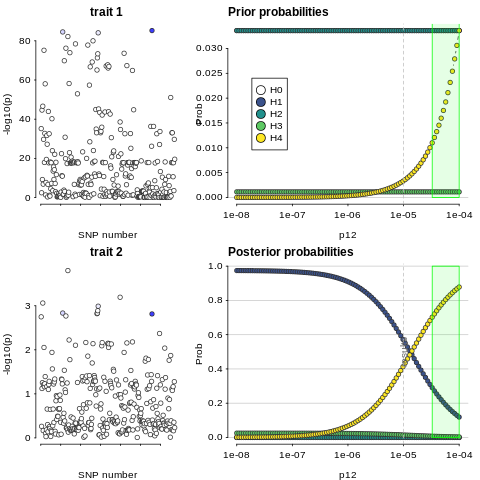

In [ ]:
%%R
sensitivity(coloc_results, "H4 > 0.7")